In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
import torch
import torch.nn.functional as F
from scipy import signal, fft

Length of signal: 8000 samples


/var/folders/rf/8gv1whtd1h372v3h09816xg80000gn/T/ipykernel_71003/3654824827.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.abs(rfft(test_signal)))


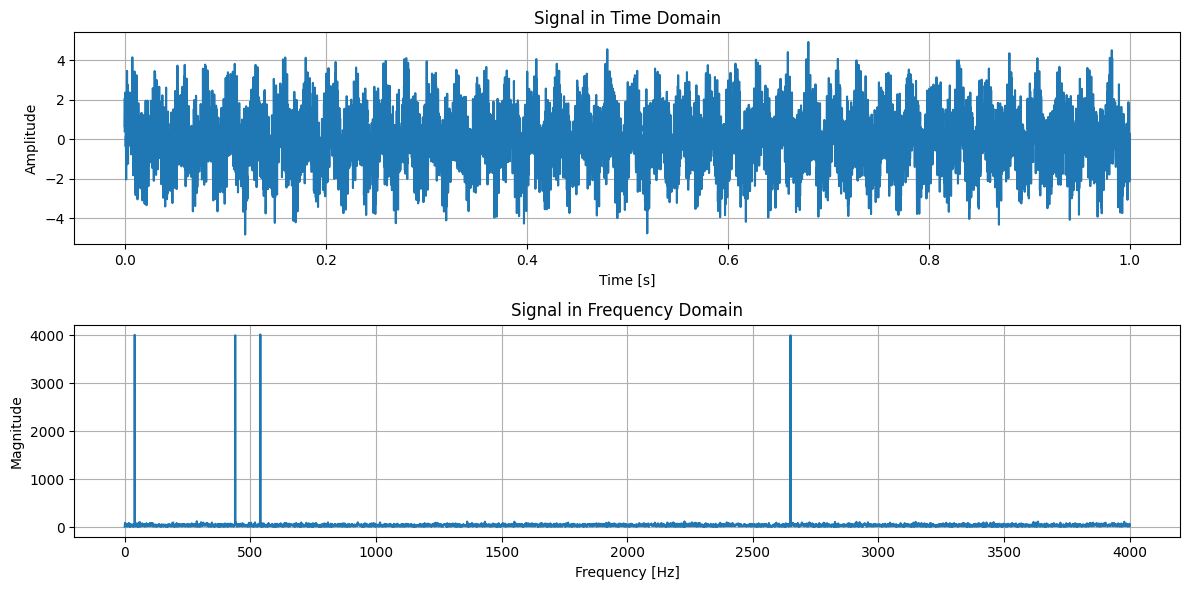

In [3]:
fs = 8000 # Sampling frequency in Hz - 44100
time = 1 # Duration in seconds - 5
print(f'Length of signal: {time * fs} samples')
samples = np.arange(time * fs) / fs

test_signal = np.sin(2 * np.pi * 40 * samples)
test_signal = test_signal + np.sin(2 * np.pi * 540 * samples)
test_signal = test_signal + np.sin(2 * np.pi * 440 * samples)
test_signal = test_signal + np.sin(2 * np.pi * 2650 * samples)

# Add some noise
noise = np.random.normal(0, 0.5, test_signal.shape)

# Combine the signal and noise
test_signal = torch.from_numpy(test_signal + noise)

# Plot the signal in time domain and frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(samples, test_signal)
plt.title('Signal in Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(np.abs(rfft(test_signal)))
plt.title('Signal in Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

/var/folders/rf/8gv1whtd1h372v3h09816xg80000gn/T/ipykernel_71003/2264718143.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.abs(rfft(y_test)))


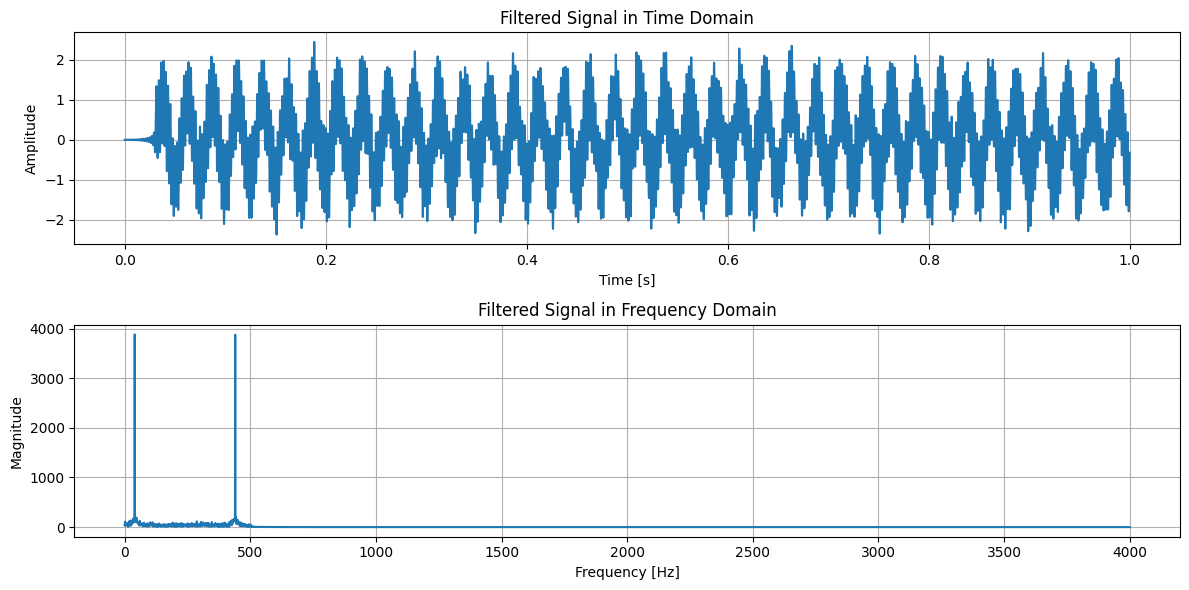

In [4]:
numtamps_test = 501

h_test = signal.firwin(numtamps_test, 500, fs=8000, pass_zero='lowpass') # 4000 / 8
h_test2 = signal.firwin(numtamps_test, [500, 1000], fs=8000, pass_zero='bandpass') # [4000 / 8, 8000 / 8]
h_test3 = signal.firwin(numtamps_test, 2200, fs=8000, pass_zero='highpass')

y_test = signal.lfilter(h_test, 1, test_signal, axis = -1)
y_test = torch.from_numpy(y_test)

y_test2 = signal.lfilter(h_test2, 1, test_signal, axis = -1)
y_test2 = torch.from_numpy(y_test2)

y_test3 = signal.lfilter(h_test3, 1, test_signal, axis = -1)
y_test3 = torch.from_numpy(y_test3)

# Plot the filtered signal in time domain and frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(samples, y_test)
plt.title('Filtered Signal in Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(np.abs(rfft(y_test)))
plt.title('Filtered Signal in Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
def mask_generator(
        batch_size: int, # Number of masks to generate
        num_banks: int, # Number of frequency bands in the filter bank
        probability_of_drop: float, # Probability of dropping a frequency band
        dtype: torch.dtype = torch.float32, # Data type of the mask
):
        shape = (num_banks,)
        length = shape[-1]
        pad_size = (num_banks // 2, num_banks // 2)

        grid = (torch.rand(batch_size, *shape) < probability_of_drop).float()
        grid = F.pad(grid, pad_size, mode='reflect')
        shift = torch.randint(low=0, high=num_banks, size=(batch_size,))
        masks = torch.empty((batch_size, *shape), dtype=dtype)

        for mask in range(batch_size):
                masks[mask] = grid[mask, shift[mask]:shift[mask] + length]
        
        return masks

In [6]:
mask_generator(
    batch_size=2,
    num_banks=12,
    probability_of_drop=0.5,
    dtype=torch.float32,
).shape

torch.Size([2, 12])

In [7]:
masks = mask_generator(
    batch_size=4,
    num_banks=12,
    probability_of_drop=0.5,
    dtype=torch.float32,
)

In [8]:
test_mask = masks[0]
test_mask2 = torch.tensor([0., # 1st bank
                           1., 
                           0., 
                           0., 
                           0., # 5th bank
                           0., 
                           0., 
                           1., 
                           0., 
                           0., # 10th bank
                           0., 
                           0.])
print(test_mask2)

tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [9]:
class FilterBank:
    def __init__(self, num_banks, fs, num_taps=None, bandwidth=None):
        self.num_banks = num_banks # Number of filter banks
        self.fs = fs # Sampling frequency
        self.num_taps = num_taps if num_taps else 8 * num_banks # Number of taps in each filter (Higher order = sharper cutoff, but more computation)
        if self.num_taps % 2 == 0: # Ensure odd number of taps
            self.num_taps += 1
        self.bandwidth = bandwidth if bandwidth else (fs / 2) /  num_banks # Bandwidth of each filter bank
        self.banks = []

        self.create_banks()

    def create_banks(self):
        h = signal.firwin(self.num_taps, self.bandwidth, fs=self.fs, pass_zero='lowpass')
        self.banks.append(h)
        band_start = self.bandwidth

        for _ in range(1, self.num_banks - 1):
            h = signal.firwin(self.num_taps, [band_start, band_start + self.bandwidth], fs=self.fs, pass_zero='bandpass')
            self.banks.append(h)
            band_start += self.bandwidth

        h = signal.firwin(self.num_taps, band_start, fs=self.fs, pass_zero='highpass')
        self.banks.append(h)
        self.banks = np.array(self.banks)
        self.banks = torch.from_numpy(self.banks).float()
    
    def apply(self, x, return_bank_borders=False):
        # Apply each filter bank to the input signal
        y = []
        bank_borders = []
        for i in range(self.num_banks):
            y.append(signal.lfilter(self.banks[i], 1, x, axis=-1))
            y[i] = torch.from_numpy(y[i])
            if return_bank_borders:
                bank_borders.append(self.bandwidth * (i + 1))
        if return_bank_borders:
            return torch.stack(y, dim=0), bank_borders
        return torch.stack(y, dim=0)
    
    def forward(self, x, mask=None, return_bank_borders=False):
        if return_bank_borders:
            y, bank_borders = self.apply(x, return_bank_borders=True)
        else:
            y = self.apply(x)

        if mask is not None:
            mask = mask.unsqueeze(1)
            y = y * mask

        if return_bank_borders:
            return torch.sum(y, dim=0), bank_borders
        return torch.sum(y, dim=0) # Sum the filtered signals along the frequency bands

/var/folders/rf/8gv1whtd1h372v3h09816xg80000gn/T/ipykernel_71003/2052284492.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.abs(rfft(filtered_signal))**2, label='Filtered Signal')


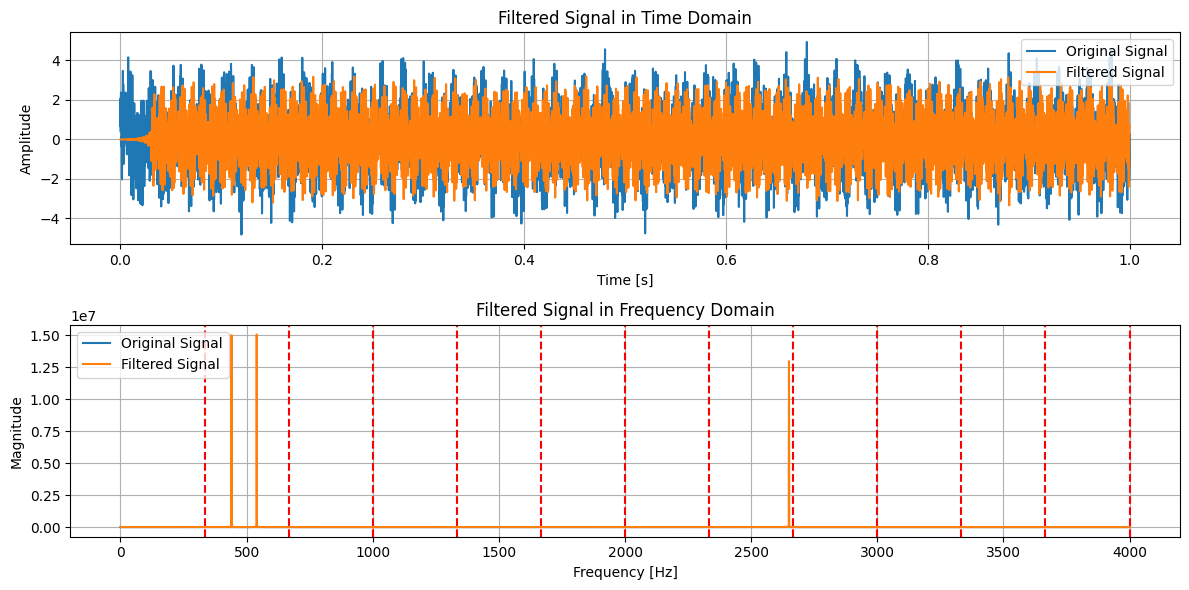

In [ ]:
filter_bank = FilterBank(num_banks=12, fs=8000, num_taps=501)
filtered_signal, bank_borders = filter_bank.forward(test_signal, mask=test_mask2, return_bank_borders=True)
# print(filtered_signal.shape)

# Plot the original and filtered signals in time domain and frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(samples, test_signal, label='Original Signal')
plt.plot(samples, filtered_signal, label='Filtered Signal')
plt.title('Filtered Signal in Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
# plt.plot(torch.abs(rfft(test_signal)), label='Original Signal')
# plt.plot(torch.abs(rfft(filtered_signal)), label='Filtered Signal')
# Plot in the frequency domain + band borders
plt.plot(rfft(test_signal), label='Original Signal')
plt.plot(rfft(filtered_signal), label='Filtered Signal')
for border in bank_borders:
    plt.axvline(x=border, color='r', linestyle='--')
plt.title('Filtered Signal in Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

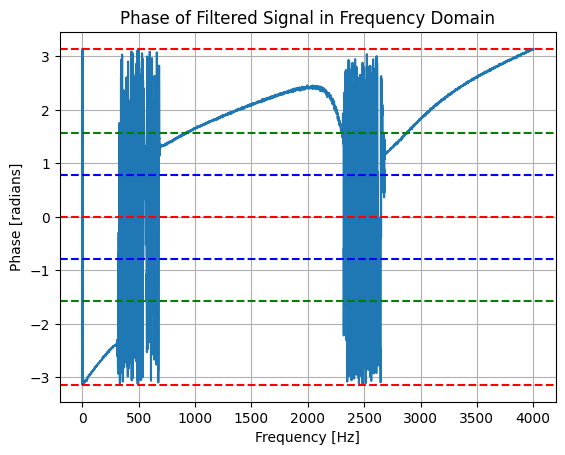

In [ ]:
plt.plot(np.angle(rfft(filtered_signal)))
plt.title('Phase of Filtered Signal in Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.axhline(0, color='r', linestyle='--')
plt.axhline(np.pi, color='r', linestyle='--')
plt.axhline(-np.pi, color='r', linestyle='--')
plt.axhline(np.pi/2, color='g', linestyle='--')
plt.axhline(-np.pi/2, color='g', linestyle='--')
plt.axhline(np.pi/4, color='b', linestyle='--')
plt.axhline(-np.pi/4, color='b', linestyle='--')
plt.grid()
plt.show()

torch.Size([8, 9])


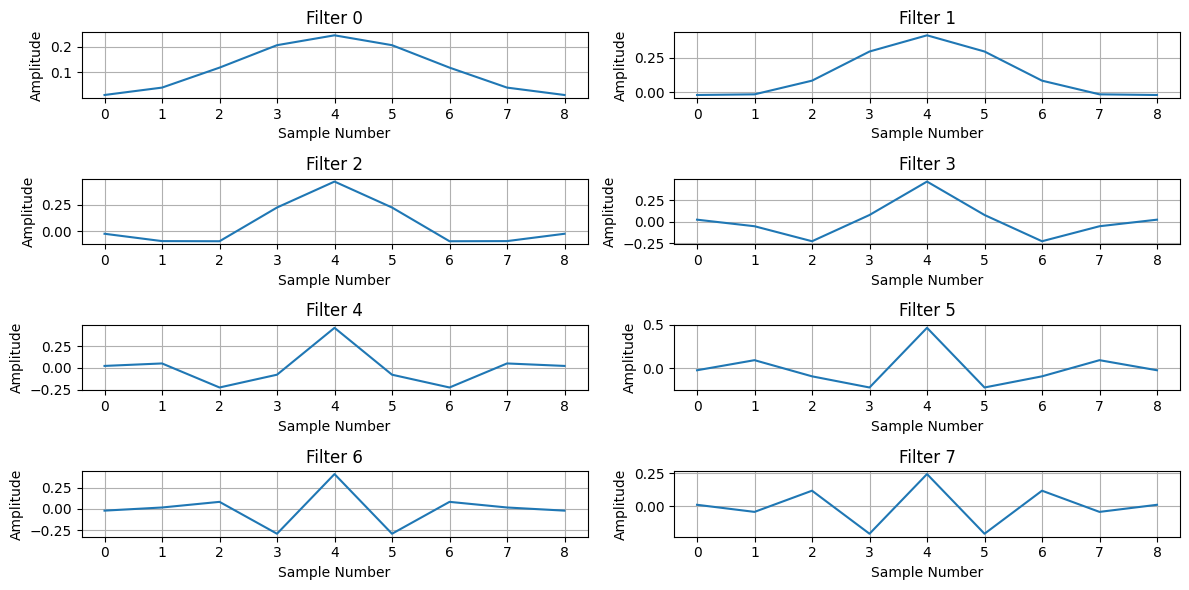

In [11]:
filter_bank = FilterBank(num_banks=8, fs=8000, num_taps=8)
print(filter_bank.banks.shape)
plt.figure(figsize=(12, 6))
for i in range(filter_bank.banks.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.plot(filter_bank.banks[i].numpy())
    plt.title(f'Filter {i}')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()